In [7]:
import requests

import boto3
import mlflow
from mlflow import pyfunc as ml_pyfunc
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [ ]:
########################################################
### Import Dataset
########################################################

In [179]:
## Import dataset
leads_dataset = pd.read_csv('leads2.csv')
leads_dataset.columns = map(str.lower, leads_dataset.columns)

In [180]:
leads_dataset

,row_number,prospect id,lead number,lead origin,lead source,do not email,do not call,converted,totalvisits,total time spent on website,page views per visit,last activity,country,specialization,what is your current occupation,what matters most to you in choosing a course,search,magazine,newspaper article,x education forums,newspaper,digital advertisement,through recommendations,receive more updates about our courses,tags,lead quality,update me on supply chain content,get updates on dm content,city,i agree to pay the amount through cheque,a free copy of mastering the interview,last notable activity
0,0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.00,Page Visited on Website,India,Others,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Mumbai,No,No,Modified
1,1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.50,Email Opened,India,Others,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Mumbai,No,No,Email Opened
2,2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.00,Email Opened,India,Business Administration,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Mumbai,No,Yes,Email Opened
3,3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.00,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Mumbai,No,No,Modified
4,4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.00,Converted to Lead,India,Others,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Mumbai,No,No,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,9235,19d6451e-fcd6-407c-b83b-48e1af805ea9,579564,Landing Page Submission,Direct Traffic,Yes,No,1,8.0,1845,2.67,Email Marked Spam,Saudi Arabia,IT Projects Management,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,High in Relevance,No,No,Mumbai,No,No,Email Marked Spam
9070,9236,82a7005b-7196-4d56-95ce-a79f937a158d,579546,Landing Page Submission,Direct Traffic,No,No,0,2.0,238,2.00,SMS Sent,India,Media and Advertising,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,wrong number given,Might be,No,No,Mumbai,No,Yes,SMS Sent
9071,9237,aac550fe-a586-452d-8d3c-f1b62c94e02c,579545,Landing Page Submission,Direct Traffic,Yes,No,0,2.0,199,2.00,SMS Sent,India,Business Administration,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,invalid number,Not Sure,No,No,Mumbai,No,Yes,SMS Sent
9072,9238,5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9,579538,Landing Page Submission,Google,No,No,1,3.0,499,3.00,SMS Sent,India,Human Resource Management,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Not Sure,No,No,Other Metro Cities,No,No,SMS Sent


In [78]:
########################################################
### Clean and Prepare Data
########################################################

In [79]:
# Create data pre-processing steps before plugging into model
leads_categorical_columns = ['lead origin',
                             'lead source',
                             'last activity',
                             'specialization',
                             'what is your current occupation',
                             'what matters most to you in choosing a course',
                             'city',
                             'last notable activity']

leads_numeric_columns = ['totalvisits',
                         'total time spent on website',
                         'page views per visit']

leads_response_columns = ['converted']

In [80]:
#split data for training, remove extras

leads_x = leads_dataset.drop(leads_response_columns, axis=1)
leads_y = leads_dataset[leads_response_columns]

leads_x_train, leads_x_test, leads_y_train, leads_y_test = train_test_split(leads_x,
                                                                            leads_y,
                                                                            train_size=0.7,
                                                                            test_size=0.3,
                                                                            random_state=5050)

In [81]:
scaler = StandardScaler()
scaler = scaler.fit(leads_x_train[leads_numeric_columns])

In [82]:
def pre_process_leads_data(df,
                           numeric_columns,
                           categorical_columns,
                           fitted_scaler,
                           train_df_columns = None):
    ## create new df with selected columns
    df.columns = map(str.lower, df.columns)
    _df = df[set(numeric_columns + categorical_columns)].copy()
    
    ## scale the numeric columns with the pre-built scaler
    _df[numeric_columns] = fitted_scaler.transform(_df[numeric_columns])
         
    # First, make categorical text lowercase
    _df[categorical_columns] = _df[categorical_columns].apply(lambda x: x.str.lower())
    # Next, create one-hot-encoded variables, add to dataframe, drop old columns
    _df_dummies = pd.get_dummies(_df[categorical_columns], drop_first=True)
    _df = pd.concat([_df, _df_dummies], axis=1)
    _df.drop(categorical_columns, axis=1, inplace = True)

    if train_df_columns:
        _df = _df.reindex(columns=train_df_columns, fill_value=0)

    return _df

In [83]:
leads_x_train_clean = pre_process_leads_data(df = leads_x_train,
                                            numeric_columns = leads_numeric_columns,
                                            categorical_columns = leads_categorical_columns,
                                            fitted_scaler = scaler)

leads_x_test_clean = pre_process_leads_data(df = leads_x_test,
                                           numeric_columns = leads_numeric_columns,
                                           categorical_columns = leads_categorical_columns,
                                           fitted_scaler = scaler,
                                           train_df_columns = leads_x_train_clean.columns.tolist())

In [84]:
########################################################
### Train and Evaluate Model
########################################################

In [108]:
from sklearn.cluster import KMeans
kmeans = KMeans(3)
kmeans.fit(leads_x_train_clean)

KMeans(n_clusters=3)

In [109]:
identified_clusters = kmeans.fit_predict(leads_x_test_clean)
identified_clusters

array([0, 2, 0, ..., 1, 0, 2])

In [110]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [111]:
leads_x_test_clean['Cluster'] = identified_clusters

In [112]:
leads_x_test_clean

,total time spent on website,totalvisits,page views per visit,lead origin_landing page submission,lead origin_lead add form,lead origin_lead import,lead source_blog,lead source_click2call,lead source_direct traffic,lead source_facebook,lead source_google,lead source_live chat,lead source_nc_edm,lead source_olark chat,lead source_organic search,lead source_press_release,lead source_reference,lead source_referral sites,lead source_social media,lead source_testone,lead source_welearn,lead source_welearnblog_home,lead source_welingak website,last activity_converted to lead,last activity_email bounced,last activity_email link clicked,last activity_email marked spam,last activity_email opened,last activity_email received,last activity_form submitted on website,last activity_had a phone conversation,last activity_olark chat conversation,last activity_page visited on website,last activity_resubscribed to emails,last activity_sms sent,last activity_unreachable,last activity_unsubscribed,last activity_view in browser link clicked,last activity_visited booth in tradeshow,specialization_business administration,specialization_e-business,specialization_e-commerce,specialization_finance management,specialization_healthcare management,specialization_hospitality management,specialization_human resource management,specialization_international business,specialization_it projects management,specialization_marketing management,specialization_media and advertising,specialization_operations management,specialization_others,specialization_retail management,specialization_rural and agribusiness,specialization_services excellence,specialization_supply chain management,specialization_travel and tourism,what is your current occupation_housewife,what is your current occupation_other,what is your current occupation_student,what is your current occupation_unemployed,what is your current occupation_working professional,what matters most to you in choosing a course_other,city_other cities,city_other cities of maharashtra,city_other metro cities,city_thane & outskirts,city_tier ii cities,last notable activity_email bounced,last notable activity_email link clicked,last notable activity_email marked spam,last notable activity_email opened,last notable activity_email received,last notable activity_form submitted on website,last notable activity_had a phone conversation,last notable activity_modified,last notable activity_olark chat conversation,last notable activity_page visited on website,last notable activity_resubscribed to emails,last notable activity_sms sent,last notable activity_unreachable,last notable activity_unsubscribed,last notable activity_view in browser link clicked,row_number,Cluster
3208,-0.725164,0.104462,0.747577,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3208,0
8819,-0.706801,-0.290676,-0.165702,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8819,2
4854,0.334381,-0.290676,-0.165702,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4854,0
7810,-0.883085,-0.685814,-1.078980,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7810,2
3174,-0.883085,-0.685814,-1.078980,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3174,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [181]:
leads_x_train_clean['row_number'] = leads_x_train_clean.index
leads_x_train_clean

,total time spent on website,totalvisits,page views per visit,lead origin_landing page submission,lead origin_lead add form,lead origin_lead import,lead source_blog,lead source_click2call,lead source_direct traffic,lead source_facebook,lead source_google,lead source_live chat,lead source_nc_edm,lead source_olark chat,lead source_organic search,lead source_press_release,lead source_reference,lead source_referral sites,lead source_social media,lead source_testone,lead source_welearn,lead source_welearnblog_home,lead source_welingak website,last activity_converted to lead,last activity_email bounced,last activity_email link clicked,last activity_email marked spam,last activity_email opened,last activity_email received,last activity_form submitted on website,last activity_had a phone conversation,last activity_olark chat conversation,last activity_page visited on website,last activity_resubscribed to emails,last activity_sms sent,last activity_unreachable,last activity_unsubscribed,last activity_view in browser link clicked,last activity_visited booth in tradeshow,specialization_business administration,specialization_e-business,specialization_e-commerce,specialization_finance management,specialization_healthcare management,specialization_hospitality management,specialization_human resource management,specialization_international business,specialization_it projects management,specialization_marketing management,specialization_media and advertising,specialization_operations management,specialization_others,specialization_retail management,specialization_rural and agribusiness,specialization_services excellence,specialization_supply chain management,specialization_travel and tourism,what is your current occupation_housewife,what is your current occupation_other,what is your current occupation_student,what is your current occupation_unemployed,what is your current occupation_working professional,what matters most to you in choosing a course_other,city_other cities,city_other cities of maharashtra,city_other metro cities,city_thane & outskirts,city_tier ii cities,last notable activity_email bounced,last notable activity_email link clicked,last notable activity_email marked spam,last notable activity_email opened,last notable activity_email received,last notable activity_form submitted on website,last notable activity_had a phone conversation,last notable activity_modified,last notable activity_olark chat conversation,last notable activity_page visited on website,last notable activity_resubscribed to emails,last notable activity_sms sent,last notable activity_unreachable,last notable activity_unsubscribed,last notable activity_view in browser link clicked,Cluster,row_number
626,-0.883085,-0.685814,-1.078980,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,626
2286,-0.122857,-0.290676,-0.165702,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2286
1776,1.491250,-0.093107,-0.394021,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1776
8336,-0.883085,-0.685814,-1.078980,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,8336
4663,0.916488,0.104462,-0.165702,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [182]:
leads_x_test_clean['row_number'] = leads_x_test_clean.index
leads_x_test_clean

,total time spent on website,totalvisits,page views per visit,lead origin_landing page submission,lead origin_lead add form,lead origin_lead import,lead source_blog,lead source_click2call,lead source_direct traffic,lead source_facebook,lead source_google,lead source_live chat,lead source_nc_edm,lead source_olark chat,lead source_organic search,lead source_press_release,lead source_reference,lead source_referral sites,lead source_social media,lead source_testone,lead source_welearn,lead source_welearnblog_home,lead source_welingak website,last activity_converted to lead,last activity_email bounced,last activity_email link clicked,last activity_email marked spam,last activity_email opened,last activity_email received,last activity_form submitted on website,last activity_had a phone conversation,last activity_olark chat conversation,last activity_page visited on website,last activity_resubscribed to emails,last activity_sms sent,last activity_unreachable,last activity_unsubscribed,last activity_view in browser link clicked,last activity_visited booth in tradeshow,specialization_business administration,specialization_e-business,specialization_e-commerce,specialization_finance management,specialization_healthcare management,specialization_hospitality management,specialization_human resource management,specialization_international business,specialization_it projects management,specialization_marketing management,specialization_media and advertising,specialization_operations management,specialization_others,specialization_retail management,specialization_rural and agribusiness,specialization_services excellence,specialization_supply chain management,specialization_travel and tourism,what is your current occupation_housewife,what is your current occupation_other,what is your current occupation_student,what is your current occupation_unemployed,what is your current occupation_working professional,what matters most to you in choosing a course_other,city_other cities,city_other cities of maharashtra,city_other metro cities,city_thane & outskirts,city_tier ii cities,last notable activity_email bounced,last notable activity_email link clicked,last notable activity_email marked spam,last notable activity_email opened,last notable activity_email received,last notable activity_form submitted on website,last notable activity_had a phone conversation,last notable activity_modified,last notable activity_olark chat conversation,last notable activity_page visited on website,last notable activity_resubscribed to emails,last notable activity_sms sent,last notable activity_unreachable,last notable activity_unsubscribed,last notable activity_view in browser link clicked,row_number,Cluster
3208,-0.725164,0.104462,0.747577,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3208,0
8819,-0.706801,-0.290676,-0.165702,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8819,2
4854,0.334381,-0.290676,-0.165702,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4854,0
7810,-0.883085,-0.685814,-1.078980,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7810,2
3174,-0.883085,-0.685814,-1.078980,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3174,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [183]:
df_concat = pd.concat([leads_x_train_clean, leads_x_test_clean], axis=0)

In [184]:
df_concat

,total time spent on website,totalvisits,page views per visit,lead origin_landing page submission,lead origin_lead add form,lead origin_lead import,lead source_blog,lead source_click2call,lead source_direct traffic,lead source_facebook,lead source_google,lead source_live chat,lead source_nc_edm,lead source_olark chat,lead source_organic search,lead source_press_release,lead source_reference,lead source_referral sites,lead source_social media,lead source_testone,lead source_welearn,lead source_welearnblog_home,lead source_welingak website,last activity_converted to lead,last activity_email bounced,last activity_email link clicked,last activity_email marked spam,last activity_email opened,last activity_email received,last activity_form submitted on website,last activity_had a phone conversation,last activity_olark chat conversation,last activity_page visited on website,last activity_resubscribed to emails,last activity_sms sent,last activity_unreachable,last activity_unsubscribed,last activity_view in browser link clicked,last activity_visited booth in tradeshow,specialization_business administration,specialization_e-business,specialization_e-commerce,specialization_finance management,specialization_healthcare management,specialization_hospitality management,specialization_human resource management,specialization_international business,specialization_it projects management,specialization_marketing management,specialization_media and advertising,specialization_operations management,specialization_others,specialization_retail management,specialization_rural and agribusiness,specialization_services excellence,specialization_supply chain management,specialization_travel and tourism,what is your current occupation_housewife,what is your current occupation_other,what is your current occupation_student,what is your current occupation_unemployed,what is your current occupation_working professional,what matters most to you in choosing a course_other,city_other cities,city_other cities of maharashtra,city_other metro cities,city_thane & outskirts,city_tier ii cities,last notable activity_email bounced,last notable activity_email link clicked,last notable activity_email marked spam,last notable activity_email opened,last notable activity_email received,last notable activity_form submitted on website,last notable activity_had a phone conversation,last notable activity_modified,last notable activity_olark chat conversation,last notable activity_page visited on website,last notable activity_resubscribed to emails,last notable activity_sms sent,last notable activity_unreachable,last notable activity_unsubscribed,last notable activity_view in browser link clicked,Cluster,row_number
626,-0.883085,-0.685814,-1.078980,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,626
2286,-0.122857,-0.290676,-0.165702,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2286
1776,1.491250,-0.093107,-0.394021,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1776
8336,-0.883085,-0.685814,-1.078980,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,8336
4663,0.916488,0.104462,-0.165702,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [185]:
leads_dataset = pd.merge(leads_dataset, df_concat, how='left', left_on = 'row_number', right_on='row_number')

In [186]:
leads_dataset.head(1)

,row_number,prospect id,lead number,lead origin,lead source,do not email,do not call,converted,totalvisits_x,total time spent on website_x,page views per visit_x,last activity,country,specialization,what is your current occupation,what matters most to you in choosing a course,search,magazine,newspaper article,x education forums,newspaper,digital advertisement,through recommendations,receive more updates about our courses,tags,lead quality,update me on supply chain content,get updates on dm content,city,i agree to pay the amount through cheque,a free copy of mastering the interview,last notable activity,total time spent on website_y,totalvisits_y,page views per visit_y,lead origin_landing page submission,lead origin_lead add form,lead origin_lead import,lead source_blog,lead source_click2call,lead source_direct traffic,lead source_facebook,lead source_google,lead source_live chat,lead source_nc_edm,lead source_olark chat,lead source_organic search,lead source_press_release,lead source_reference,lead source_referral sites,...,last activity_sms sent,last activity_unreachable,last activity_unsubscribed,last activity_view in browser link clicked,last activity_visited booth in tradeshow,specialization_business administration,specialization_e-business,specialization_e-commerce,specialization_finance management,specialization_healthcare management,specialization_hospitality management,specialization_human resource management,specialization_international business,specialization_it projects management,specialization_marketing management,specialization_media and advertising,specialization_operations management,specialization_others,specialization_retail management,specialization_rural and agribusiness,specialization_services excellence,specialization_supply chain management,specialization_travel and tourism,what is your current occupation_housewife,what is your current occupation_other,what is your current occupation_student,what is your current occupation_unemployed,what is your current occupation_working professional,what matters most to you in choosing a course_other,city_other cities,city_other cities of maharashtra,city_other metro cities,city_thane & outskirts,city_tier ii cities,last notable activity_email bounced,last notable activity_email link clicked,last notable activity_email marked spam,last notable activity_email opened,last notable activity_email received,last notable activity_form submitted on website,last notable activity_had a phone conversation,last notable activity_modified,last notable activity_olark chat conversation,last notable activity_page visited on website,last notable activity_resubscribed to emails,last notable activity_sms sent,last notable activity_unreachable,last notable activity_unsubscribed,last notable activity_view in browser link clicked,Cluster
0,0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,India,Others,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Mumbai,No,No,Modified,-0.883085,-0.685814,-1.07898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [187]:
sales_person = pd.DataFrame.from_dict({0.0: 'Anirban',
 1.0: 'Puneet',
 2.0: 'Mokshita',
}, orient='index', columns=['Best Case Sales Person'])

sales_person['Cluster'] = sales_person.index
sales_person

,Best Case Sales Person,Cluster
0.0,Anirban,0.0
1.0,Puneet,1.0
2.0,Mokshita,2.0


In [188]:
leads_dataset = pd.merge(leads_dataset, sales_person, how='left')

In [189]:
leads_dataset

,row_number,prospect id,lead number,lead origin,lead source,do not email,do not call,converted,totalvisits_x,total time spent on website_x,page views per visit_x,last activity,country,specialization,what is your current occupation,what matters most to you in choosing a course,search,magazine,newspaper article,x education forums,newspaper,digital advertisement,through recommendations,receive more updates about our courses,tags,lead quality,update me on supply chain content,get updates on dm content,city,i agree to pay the amount through cheque,a free copy of mastering the interview,last notable activity,total time spent on website_y,totalvisits_y,page views per visit_y,lead origin_landing page submission,lead origin_lead add form,lead origin_lead import,lead source_blog,lead source_click2call,lead source_direct traffic,lead source_facebook,lead source_google,lead source_live chat,lead source_nc_edm,lead source_olark chat,lead source_organic search,lead source_press_release,lead source_reference,lead source_referral sites,...,last activity_unreachable,last activity_unsubscribed,last activity_view in browser link clicked,last activity_visited booth in tradeshow,specialization_business administration,specialization_e-business,specialization_e-commerce,specialization_finance management,specialization_healthcare management,specialization_hospitality management,specialization_human resource management,specialization_international business,specialization_it projects management,specialization_marketing management,specialization_media and advertising,specialization_operations management,specialization_others,specialization_retail management,specialization_rural and agribusiness,specialization_services excellence,specialization_supply chain management,specialization_travel and tourism,what is your current occupation_housewife,what is your current occupation_other,what is your current occupation_student,what is your current occupation_unemployed,what is your current occupation_working professional,what matters most to you in choosing a course_other,city_other cities,city_other cities of maharashtra,city_other metro cities,city_thane & outskirts,city_tier ii cities,last notable activity_email bounced,last notable activity_email link clicked,last notable activity_email marked spam,last notable activity_email opened,last notable activity_email received,last notable activity_form submitted on website,last notable activity_had a phone conversation,last notable activity_modified,last notable activity_olark chat conversation,last notable activity_page visited on website,last notable activity_resubscribed to emails,last notable activity_sms sent,last notable activity_unreachable,last notable activity_unsubscribed,last notable activity_view in browser link clicked,Cluster,Best Case Sales Person
0,0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.00,Page Visited on Website,India,Others,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Mumbai,No,No,Modified,-0.883085,-0.685814,-1.078980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,Mokshita
1,1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.50,Email Opened,India,Others,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Mumbai,No,No,Email Opened,0.354580,0.302031,0.062618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Anirban
2,2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.00

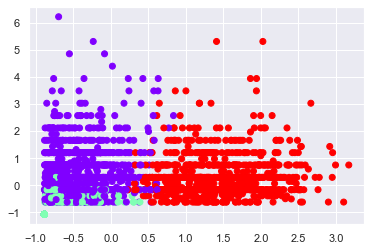

In [47]:
data_with_clusters = leads_x_test_clean.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['total time spent on website'],data_with_clusters['page views per visit'],c=data_with_clusters['Clusters'],cmap='rainbow')

In [190]:
leads_dataset = leads_dataset[['prospect id','Best Case Sales Person']]

In [148]:
leads_dataset.to_csv('leads_table.csv')

In [191]:
## Import dataset
leads_dataset2 = pd.read_csv('Leads (2).csv')


In [192]:
leads_dataset2

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.00,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.50,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.00,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.00,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.00,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,19d6451e-fcd6-407c-b83b-48e1af805ea9,579564,Landing Page Submission,Direct Traffic,Yes,No,1,8.0,1845,2.67,Email Marked Spam,Saudi Arabia,IT Projects Management,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,High in Relevance,No,No,Potential Lead,Mumbai,02.Medium,01.High,15.0,17.0,No,No,Email Marked Spam
9236,82a7005b-7196-4d56-95ce-a79f937a158d,579546,Landing Page Submission,Direct Traffic,No,No,0,2.0,238,2.00,SMS Sent,India,Media and Advertising,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,wrong number given,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,19.0,No,Yes,SMS Sent
9237,aac550fe-a586-452d-8d3c-f1b62c94e02c,579545,Landing Page Submission,Direct Traffic,Yes,No,0,2.0,199,2.00,SMS Sent,India,Business Administration,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,invalid number,Not Sure,No,No,Potential Lead,Mumbai,02.Medium,01.High,13.0,20.0,No,Yes,SMS Sent
9238,5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9,579538,Landing Page Submission,Google,No,No,1,3.0,499,3.00,SMS Sent,India,Human Resource Management,Online Search,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,Other Metro Cities,02.Medium,02.Medium,15.0,16.0,No,No,SMS Sent


In [193]:
leads_dataset2 = pd.merge(leads_dataset2, leads_dataset, how='left', left_on = 'Prospect ID', right_on='prospect id')

In [194]:
leads_dataset2

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,prospect id,Best Case Sales Person
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.00,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified,7927b2df-8bba-4d29-b9a2-b6e0beafe620,Mokshita
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.50,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened,2a272436-5132-4136-86fa-dcc88c88f482,Anirban
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.00,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,Puneet
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.00,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,Anirban
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.00,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified,3256f628-e534-4826-9d63-4a8b88782852,Puneet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,19d6451e-fcd6-407c-b83b-48e1af805ea9,579564,Landing Page Submission,Direct Traffic,Yes,No,1,8.0,1845,2.67,Email Marked Spam,Saudi Arabia,IT Projects Management,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,High in Relevance,No,No,Potential Lead,Mumbai,02.Medium,01.High,15.0,17.0,No,No,Email Marked Spam,19d6451e-fcd6-407c-b83b-48e1af805ea9,NaN
9236,82a7005b-7196-4d56-95ce-a79f937a158d,579546,Landing Page Submission,Direct Traffic,No,No,0,2.0,238,2.00,SMS Sent,India,Media and Advertising,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,wrong number given,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,19.0,No,Yes,SMS Sent,82a7005b-7196-4d56-95ce-a79f937a158d,NaN
9237,aac550fe-a586-452d-8d3c-f1b62c94e02c,579545,Landing Page Submission,Direct Traffic,Yes,No,0,2.0,199,2.00,SMS Sent,India,Business Administration,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,invalid number,Not Sure,No,No,Potential Lead,Mumbai,02.Medium,01.High,13.0,20.0,No,Yes,SMS Sent,aac550fe-a586-452d-8d3c-f1b62c94e02c,NaN
9238,5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9,579538,Landing Page Submission,Google,No,No,1,3.0,499,3.00,SMS Sent,India,Human Resource Management,Online Search,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,Other Metro Cities,02.Mediu

In [196]:
leads_dataset2 = leads_dataset2[leads_dataset2['Best Case Sales Person'].notna()]

In [197]:
leads_dataset2

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,prospect id,Best Case Sales Person
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified,7927b2df-8bba-4d29-b9a2-b6e0beafe620,Mokshita
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened,2a272436-5132-4136-86fa-dcc88c88f482,Anirban
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,Puneet
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,Anirban
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified,3256f628-e534-4826-9d63-4a8b88782852,Puneet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,091a1e91-405f-44fa-ac2e-61498a96af62,580819,API,Google,No,No,0,6.0,1458,2.0,Email Opened,India,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,NaN,01.High,02.Medium,16.0,15.0,No,No,Email Opened,091a1e91-405f-44fa-ac2e-61498a96af62,Puneet
9070,5ab2d891-8bd2-41dc-8663-45fb0afcdb35,580808,Landing Page Submission,Direct Traffic,No,No,0,4.0,301,2.0,Email Opened,India,Marketing Management,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,Mumbai,02.Medium,01.High,15.0,18.0,No,Yes,Email Opened,5ab2d891-8bd2-41dc-8663-45fb0afcdb35,Mokshita
9071,cc5a3b9b-b998-4d43-8bbb-42e22b3dac26,580800,API,Olark Chat,No,No,0,0.0,0,0.0,Olark Chat Conversation,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,NaN,NaN,No,No,NaN,NaN,01.High,02.Medium,17.0,15.0,No,No,Modified,cc5a3b9b-b998-4d43-8bbb-42e22b3dac26,Anirban
9072,53f209d0-d223-4d29-b1e4-4f001dc10933,580799,API,Google,No,No,0,8.0,984,8.0,Email Opened,India,"Banking, Investment And Insurance",Multiple Sources,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,NaN,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,18.0,No,No,Modified,53f209d0-d223-4d29-b1e4-4f001dc10933,Anirban


In [198]:
leads_dataset2.to_csv("leads_final.csv")